# TF-IDF 调参结果分析（`summary.csv`）

本 Notebook 将：
1. 自动定位 `summary.csv`（或 `summary_metrics.csv`）。
2. 清洗和解析参数列（`analyzer / ngram / max_features / alpha / penalty / resample / calibrate`）。
3. 统计已完成/失败的实验数量，展示前 20 个最优组合。
4. 使用 **matplotlib**（不使用 seaborn、不设置颜色）绘制多个图：
   - 指标分布直方图
   - Top-10 组合条形图
   - `f1_weighted` 与 `hit@1` 的散点图
   - 按 `analyzer`/`penalty` 的分组箱线图
5. 生成几个透视表，便于筛选最优配置。

> 依赖：`pandas`, `numpy`, `matplotlib`, `tqdm`（可选）。


In [28]:
import os, re, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 保证图在 notebook 中内联显示
# （在你本地运行时有效，此处保留）
# %matplotlib inline

# 可能的默认位置
DEFAULT_DIR = Path("../output/tfidf_tune")
CANDIDATES = [
    DEFAULT_DIR / "summary.csv",
    DEFAULT_DIR / "summary_metrics.csv",
    Path("./summary.csv"),
    Path("./summary_metrics.csv"),
]

csv_path = None
for p in CANDIDATES:
    if p.exists():
        csv_path = p
        break

print("Detected summary path:", csv_path)

if csv_path is None:
    raise FileNotFoundError(
        "未找到 summary CSV。请将文件放到 ./output/tfidf_tune/summary.csv 或 summary_metrics.csv，"
        "或修改上面的 CANDIDATES 路径。"
    )

df = pd.read_csv(csv_path)
print("Rows:", len(df))
print("Columns:", list(df.columns))
df.head(3)


Detected summary path: ../output/tfidf_tune/summary_metrics.csv
Rows: 144
Columns: ['experiment', 'outdir', 'returncode', 'duration_sec', 'log_path', 'metrics_path', 'status', 'accuracy', 'f1_weighted', 'f1_macro', 'hit@1', 'hit@3', 'hit@5', 'hit@10']


,experiment,outdir,returncode,duration_sec,log_path,metrics_path,status,accuracy,f1_weighted,f1_macro,hit@1,hit@3,hit@5,hit@10
0,achar_n2-4_f100000_alpha0.0001_penelasticnet_ros,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,0,NaN,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,done,0.582545,0.548470,0.497112,0.582545,0.815983,0.881178,0.928496
1,achar_n2-4_f100000_alpha0.0001_penl2_ros,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,0,NaN,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,done,0.618297,0.584472,0.501745,0.618297,0.832808,0.888538,0.937960
2,achar_n2-4_f100000_alpha1e-05_penelasticnet_ros,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,0,NaN,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,done,0.652997,0.619586,0.490366,0.652997,0.856993,0.910620,0.954784


In [29]:
# ---- 解析 experiment 名称中的超参（与你生成的命名格式保持一致）
# 例如：a{analyzer}_n{nmin}-{nmax}_f{maxf}_alpha{alpha}_pen{penalty}_{resample}
# 示例：achar_wb_n3-5_f50000_alpha1e-05_penelasticnet_ros

def parse_experiment_name(name: str):
    out = {
        "analyzer": None, "ngram_min": np.nan, "ngram_max": np.nan,
        "max_features": np.nan, "alpha": np.nan, "penalty": None, "resample": None
    }
    try:
        m = re.search(r"^a([^_]+)_n(\d+)-(\d+)_f(\d+)_alpha([0-9.eE+-]+)_pen([a-zA-Z0-9_]+)_([a-zA-Z0-9_]+)$", name)
        if m:
            out["analyzer"] = m.group(1)
            out["ngram_min"] = int(m.group(2))
            out["ngram_max"] = int(m.group(3))
            out["max_features"] = int(m.group(4))
            out["alpha"] = float(m.group(5))
            out["penalty"] = m.group(6)
            out["resample"] = m.group(7)
    except Exception:
        pass
    return out

parsed = df["experiment"].astype(str).apply(parse_experiment_name).apply(pd.Series)
for k in parsed.columns:
    if k not in df.columns:
        df[k] = parsed[k]

# 兼容 calibrate 字段（有可能在 CSV 中）
if "calibrate" not in df.columns:
    # 从文件夹/其他列中猜不到就置为空
    df["calibrate"] = ""

# 过滤 status
if "status" in df.columns:
    print(df["status"].value_counts(dropna=False))

# 显示解析后的前几行
df.head(5)


status
done    144
Name: count, dtype: int64


,experiment,outdir,returncode,duration_sec,log_path,metrics_path,status,accuracy,f1_weighted,f1_macro,...,hit@5,hit@10,analyzer,ngram_min,ngram_max,max_features,alpha,penalty,resample,calibrate
0,achar_n2-4_f100000_alpha0.0001_penelasticnet_ros,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,0,NaN,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,done,0.582545,0.548470,0.497112,...,0.881178,0.928496,char,2.0,4.0,100000.0,0.00010,elasticnet,ros,
1,achar_n2-4_f100000_alpha0.0001_penl2_ros,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,0,NaN,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,done,0.618297,0.584472,0.501745,...,0.888538,0.937960,char,2.0,4.0,100000.0,0.00010,l2,ros,
2,achar_n2-4_f100000_alpha1e-05_penelasticnet_ros,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,0,NaN,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,done,0.652997,0.619586,0.490366,...,0.910620,0.954784,char,2.0,4.0,100000.0,0.00001,elasticnet,ros,
3,achar_n2-4_f100000_alpha1e-05_penl2_ros,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,0,NaN,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,done,0.651945,0.613430,0.476518,...,0.904311,0.952681,char,2.0,4.0,100000.0,0.00001,l2,ros,
4,achar_n2-4_f100000_alpha5e-05_penelasticnet_ros,output/tfidf_tune/achar_n2-4_f100000_alpha5e-0...,0,NaN,output/tfidf_tune/achar_n2-4_f100000_alpha5e-0...,output/tfidf_tune/achar_n2-4_f100000_alpha5e-0...,done,0.629863,0.593368,0.505392,...,0.906414,0.949527,char,2.0,4.0,100000.0,0.00005,elasticnet,ros,


In [30]:
# 统计完成/失败数量
def safe_val_counts(series):
    try:
        return series.value_counts(dropna=False)
    except Exception:
        return pd.Series([], dtype=int)

stats = {}
if "status" in df.columns:
    stats["status_counts"] = safe_val_counts(df["status"])
if "returncode" in df.columns:
    stats["returncode_counts"] = safe_val_counts(df["returncode"])

print("=== Basic Stats ===")
for k, v in stats.items():
    print(f"\n{k}:\n{v}")

# 哪些指标列可用
metric_candidates = ["accuracy","f1_weighted","f1_macro","hit@1","hit@3","hit@5","hit@10"]
available_metrics = [m for m in metric_candidates if m in df.columns]
print("\nAvailable metrics:", available_metrics)

# 丢弃明显失败的记录（无指标且 returncode!=0 的）
def is_valid_row(row):
    has_any_metric = any(pd.notna(row.get(m)) for m in available_metrics)
    rc = row.get("returncode")
    if pd.isna(rc):
        return has_any_metric
    try:
        return int(rc) == 0 and has_any_metric
    except Exception:
        return has_any_metric

df_valid = df[df.apply(is_valid_row, axis=1)].copy()
print("Valid rows:", len(df_valid))
df_valid.head(3)


=== Basic Stats ===

status_counts:
status
done    144
Name: count, dtype: int64

returncode_counts:
returncode
0    144
Name: count, dtype: int64

Available metrics: ['accuracy', 'f1_weighted', 'f1_macro', 'hit@1', 'hit@3', 'hit@5', 'hit@10']
Valid rows: 144


,experiment,outdir,returncode,duration_sec,log_path,metrics_path,status,accuracy,f1_weighted,f1_macro,...,hit@5,hit@10,analyzer,ngram_min,ngram_max,max_features,alpha,penalty,resample,calibrate
0,achar_n2-4_f100000_alpha0.0001_penelasticnet_ros,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,0,NaN,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,done,0.582545,0.548470,0.497112,...,0.881178,0.928496,char,2.0,4.0,100000.0,0.00010,elasticnet,ros,
1,achar_n2-4_f100000_alpha0.0001_penl2_ros,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,0,NaN,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,output/tfidf_tune/achar_n2-4_f100000_alpha0.00...,done,0.618297,0.584472,0.501745,...,0.888538,0.937960,char,2.0,4.0,100000.0,0.00010,l2,ros,
2,achar_n2-4_f100000_alpha1e-05_penelasticnet_ros,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,0,NaN,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,output/tfidf_tune/achar_n2-4_f100000_alpha1e-0...,done,0.652997,0.619586,0.490366,...,0.910620,0.954784,char,2.0,4.0,100000.0,0.00001,elasticnet,ros,


In [31]:
# 选一个主指标排序（若没有 f1_weighted，则退化到 accuracy）
main_metric = "f1_weighted" if "f1_weighted" in df_valid.columns else ("accuracy" if "accuracy" in df_valid.columns else None)
if main_metric is None:
    raise RuntimeError("未在 CSV 中找到可排序的主指标（期待 f1_weighted 或 accuracy）。")

topk = (df_valid
        .sort_values(by=[main_metric], ascending=False)
        .head(20)
        .reset_index(drop=True))

print(f"Top-20 by {main_metric}:")
topk_cols = ["experiment","analyzer","ngram_min","ngram_max","max_features","alpha","penalty","resample","calibrate", main_metric]
topk[topk_cols]


Top-20 by f1_weighted:


,experiment,analyzer,ngram_min,ngram_max,max_features,alpha,penalty,resample,calibrate,f1_weighted
0,achar_n2-4_f50000_alpha1e-05_penelasticnet_ros,char,2.0,4.0,50000.0,0.00001,elasticnet,ros,,0.626658
1,achar_wb_n2-4_f50000_alpha1e-05_penelasticnet_ros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.624682
2,achar_wb_n2-5_f50000_alpha1e-05_penelasticnet_ros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.622582
3,achar_n2-4_f50000_alpha1e-05_penl2_ros,char,2.0,4.0,50000.0,0.00001,l2,ros,,0.620982
4,achar_wb_n2-4_f100000_alpha1e-05_penelasticnet...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.620385
5,achar_n2-4_f100000_alpha1e-05_penelasticnet_ros,char,2.0,4.0,100000.0,0.00001,elasticnet,ros,,0.619586
6,achar_wb_n2-5_f100000_alpha1e-05_penelasticnet...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.619355
7,achar_n2-5_f50000_alpha1e-05_penl2_ros,char,2.0,5.0,50000.0,0.00001,l2,ros,,0.617460
8,achar_wb_n2-4_f50000_alpha1e-05_penl2_ros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.616302
9,achar_n2-4_f50000_alpha5e-05_penl2_ros,char,2.0,4.0,50000.0,0.00005,l2,ros,,0.615670


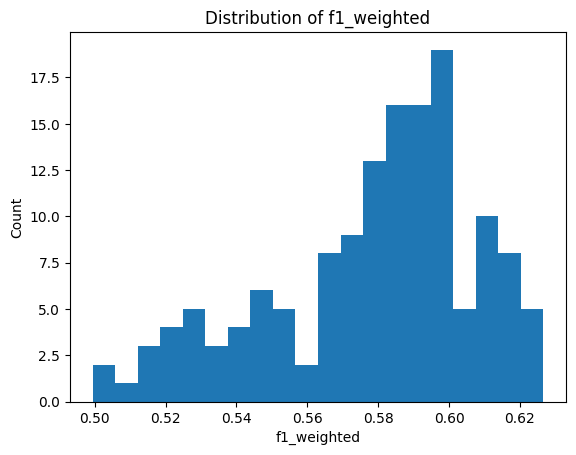

In [32]:
# 直方图：主指标分布
vals = df_valid[main_metric].dropna().astype(float).values

plt.figure()
plt.hist(vals, bins=20)
plt.title(f"Distribution of {main_metric}")
plt.xlabel(main_metric)
plt.ylabel("Count")
plt.show()


/tmp/ipykernel_13316/2823390358.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


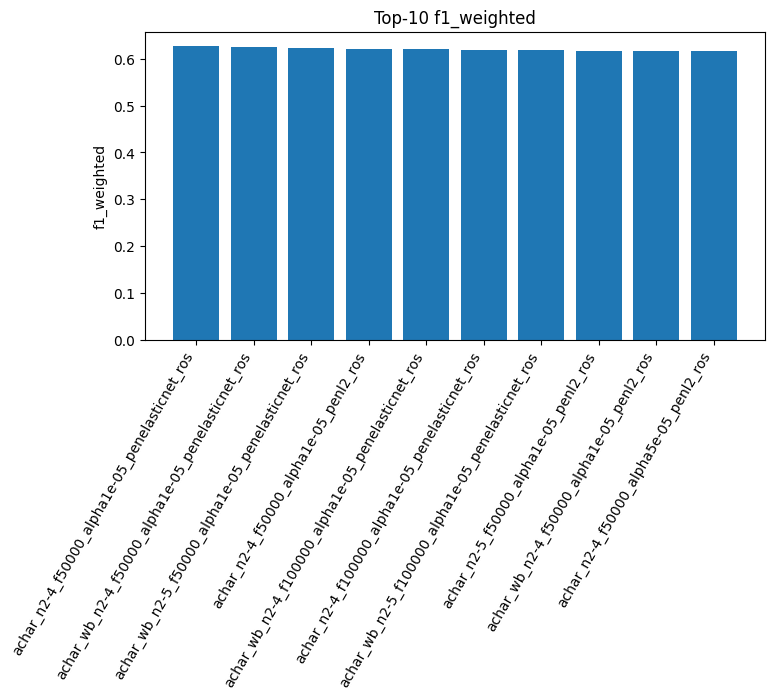

In [33]:
# Top-10 条形图
top10 = topk.head(10)
plt.figure(figsize=(8, 4))
plt.bar(range(len(top10)), top10[main_metric].astype(float).values)
plt.xticks(range(len(top10)), top10["experiment"].astype(str).values, rotation=60, ha="right")
plt.ylabel(main_metric)
plt.title(f"Top-10 {main_metric}")
plt.tight_layout()
plt.show()


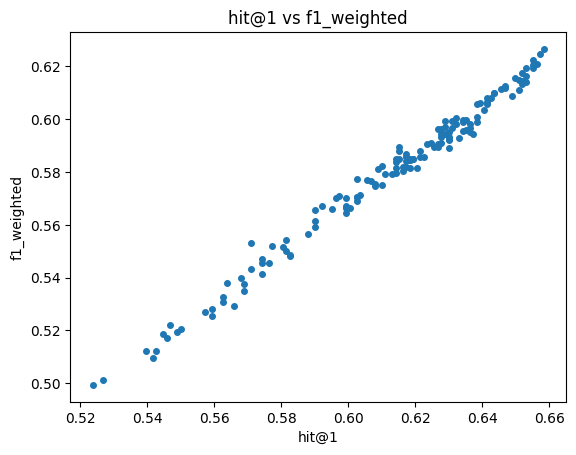

In [34]:
# 散点图：f1_weighted vs hit@1（若两者均存在）
if ("f1_weighted" in df_valid.columns) and ("hit@1" in df_valid.columns):
    x = df_valid["hit@1"].astype(float).values
    y = df_valid["f1_weighted"].astype(float).values

    plt.figure()
    plt.scatter(x, y, s=16)
    plt.xlabel("hit@1")
    plt.ylabel("f1_weighted")
    plt.title("hit@1 vs f1_weighted")
    plt.show()
else:
    print("列不足，跳过散点图（需要 f1_weighted 与 hit@1）。")


/tmp/ipykernel_13316/2399448341.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showmeans=True)


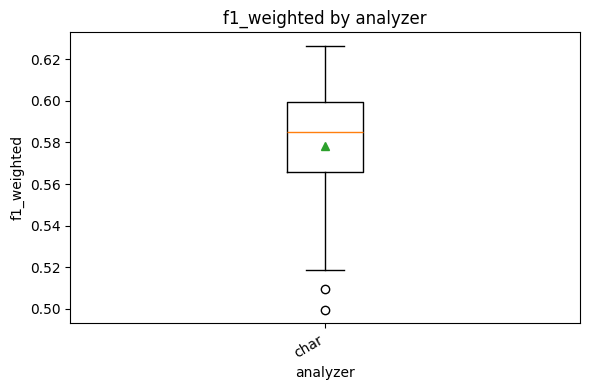

/tmp/ipykernel_13316/2399448341.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showmeans=True)


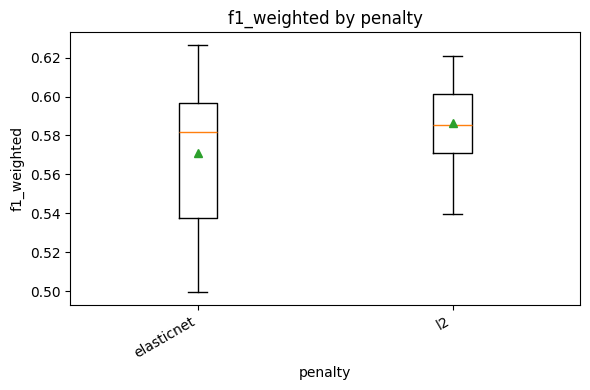

/tmp/ipykernel_13316/2399448341.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showmeans=True)


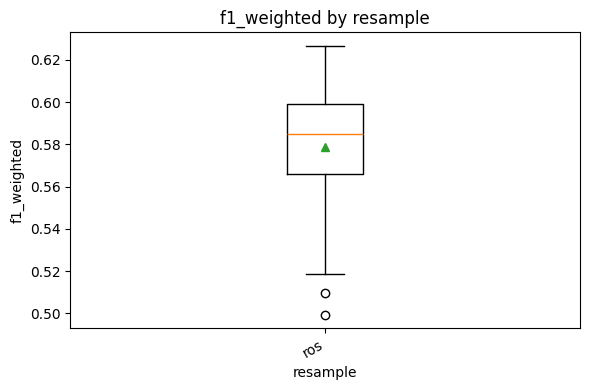

/tmp/ipykernel_13316/2399448341.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showmeans=True)


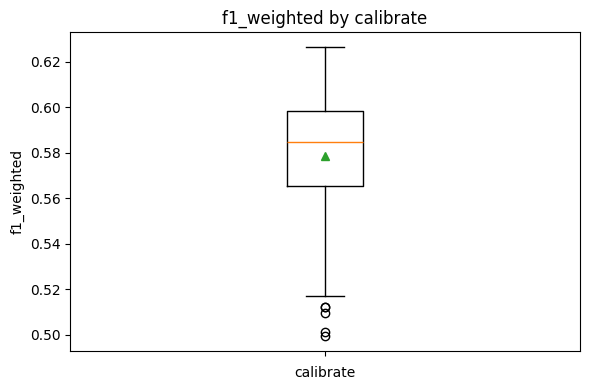

In [35]:
# 分组箱线图：按 analyzer / penalty 看主指标
def boxplot_by(colname):
    groups = []
    labels = []
    for key, sub in df_valid.groupby(colname):
        vals = sub[main_metric].dropna().astype(float).values
        if len(vals) > 0:
            groups.append(vals)
            labels.append(str(key))
    if len(groups) == 0:
        print(f"无有效数据绘制箱线图：{colname}")
        return
    plt.figure(figsize=(max(6, len(groups)*0.8), 4))
    plt.boxplot(groups, labels=labels, showmeans=True)
    plt.title(f"{main_metric} by {colname}")
    plt.xlabel(colname)
    plt.ylabel(main_metric)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

for col in ["analyzer","penalty","resample","calibrate"]:
    if col in df_valid.columns:
        boxplot_by(col)


In [36]:
# 透视表（平均值）：不同维度下主指标的均值，帮助观察趋势
def safe_pivot(index, columns=None):
    try:
        pt = pd.pivot_table(df_valid, index=index, columns=columns, values=main_metric, aggfunc="mean")
        return pt.sort_values(by=pt.columns.tolist()[0] if columns is not None else None, ascending=False, na_position="last")
    except Exception as e:
        print("pivot error:", e)
        return None

pt1 = safe_pivot(index=["analyzer","penalty"])
pt2 = safe_pivot(index=["max_features"])
pt3 = safe_pivot(index=["ngram_min","ngram_max"])

print("\nPivot: analyzer x penalty (mean)")
display(pt1)

print("\nPivot: max_features (mean)")
display(pt2)

print("\nPivot: ngram_min x ngram_max (mean)")
display(pt3)


pivot error: None
pivot error: None
pivot error: None

Pivot: analyzer x penalty (mean)


None


Pivot: max_features (mean)


None


Pivot: ngram_min x ngram_max (mean)


None

In [37]:
# 将解析/清洗后的数据另存，方便后续直接用
out_clean = DEFAULT_DIR / "summary_cleaned.csv"
df_valid.to_csv(out_clean, index=False, encoding="utf-8")
print("已输出清洗后的文件：", out_clean)


已输出清洗后的文件： ../output/tfidf_tune/summary_cleaned.csv


满足条件的实验数量：100 / 144


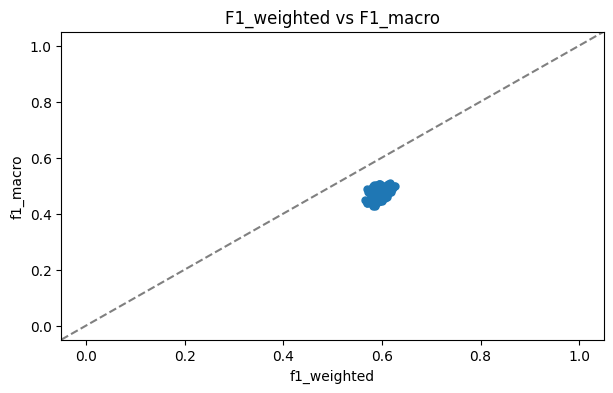

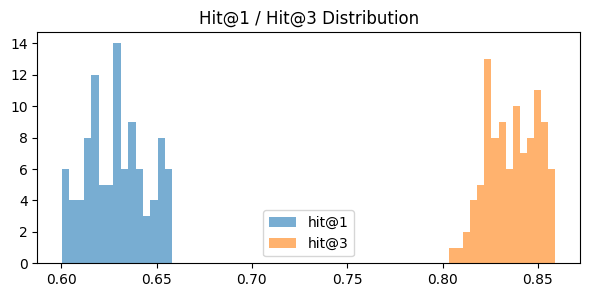

最均衡的组合：


,experiment,analyzer,ngram_min,ngram_max,max_features,alpha,penalty,resample,calibrate,hit@1,hit@3,f1_weighted,f1_macro,f1_balance_gap
109,achar_wb_n3-4_f100000_alpha0.0001_penl2_ros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.602524,0.824395,0.568937,0.488165,0.080772


筛选结果已保存： ../output/tfidf_tune/best_filtered.csv


In [38]:
# === 条件筛选：hit@3 > 0.8 且 hit@1 > 0.6 ===
cond = (df_valid["hit@3"] > 0.8) & (df_valid["hit@1"] > 0.6)
df_sel = df_valid[cond].copy()
print(f"满足条件的实验数量：{len(df_sel)} / {len(df_valid)}")

if len(df_sel) == 0:
    raise ValueError("没有满足 hit@3>0.8 且 hit@1>0.6 的实验。")

# === F1 均衡度 ===
# 定义一个衡量两种 F1 差距的指标（差值越小越均衡）
if "f1_weighted" in df_sel.columns and "f1_macro" in df_sel.columns:
    df_sel["f1_balance_gap"] = (df_sel["f1_weighted"] - df_sel["f1_macro"]).abs()
else:
    df_sel["f1_balance_gap"] = np.nan

# === 可视化分布 ===
plt.figure(figsize=(7,4))
plt.scatter(df_sel["f1_weighted"], df_sel["f1_macro"], s=25)
plt.xlabel("f1_weighted")
plt.ylabel("f1_macro")
plt.title("F1_weighted vs F1_macro")
plt.axline((0,0),(1,1), color="gray", linestyle="--")  # 理想均衡线
plt.show()

# 再绘制 hit@1、hit@3 的分布
plt.figure(figsize=(7,3))
plt.hist(df_sel["hit@1"], bins=15, alpha=0.6, label="hit@1")
plt.hist(df_sel["hit@3"], bins=15, alpha=0.6, label="hit@3")
plt.legend()
plt.title("Hit@1 / Hit@3 Distribution")
plt.show()

# === 按均衡度排序，打印最优组合 ===
best = df_sel.sort_values(by="f1_balance_gap").head(1)
cols_show = [
    "experiment","analyzer","ngram_min","ngram_max","max_features","alpha",
    "penalty","resample","calibrate",
    "hit@1","hit@3","f1_weighted","f1_macro","f1_balance_gap"
]
print("最均衡的组合：")
display(best[cols_show])

# 若想保存结果：
out_best = DEFAULT_DIR / "best_filtered.csv"
df_sel.to_csv(out_best, index=False, encoding="utf-8")
print("筛选结果已保存：", out_best)

=== 最均衡 Top-5 组合 ===


,experiment,analyzer,ngram_min,ngram_max,max_features,alpha,penalty,resample,calibrate,hit@1,hit@3,hit@5,hit@10,f1_weighted,f1_macro,f1_balance_gap
0,achar_wb_n3-4_f100000_alpha0.0001_penl2_ros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.602524,0.824395,0.876972,0.929548,0.568937,0.488165,0.080772
1,achar_wb_n2-4_f100000_alpha0.0001_penl2_ros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.616193,0.839117,0.887487,0.936909,0.582002,0.500265,0.081737
2,achar_n2-4_f100000_alpha0.0001_penl2_ros,char,2.0,4.0,100000.0,0.0001,l2,ros,,0.618297,0.832808,0.888538,0.937960,0.584472,0.501745,0.082727
3,achar_n2-5_f100000_alpha0.0001_penl2_ros,char,2.0,5.0,100000.0,0.0001,l2,ros,,0.617245,0.828601,0.883281,0.934805,0.584376,0.499102,0.085274
4,achar_wb_n2-4_f50000_alpha0.0001_penl2_ros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0.621451,0.841220,0.887487,0.939012,0.588157,0.502448,0.085709


已保存： ../output/tfidf_tune/top5_balanced.csv


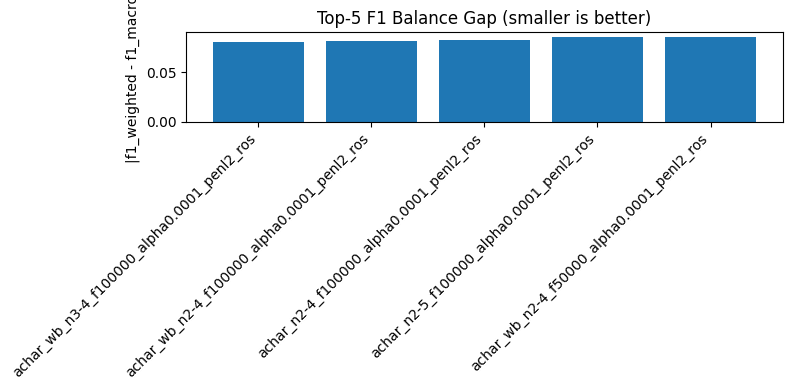

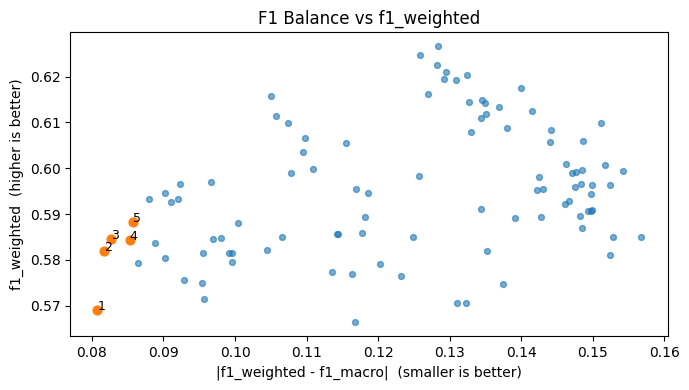

In [41]:
# === 若没定义 df_sel，则按条件重算（hit@3>0.8 & hit@1>0.6） ===
need_rebuild = False
if "df_sel" not in globals():
    need_rebuild = True
else:
    try:
        _ = df_sel.shape  # sanity check
    except Exception:
        need_rebuild = True

if need_rebuild:
    req_cols = {"hit@1","hit@3","f1_weighted","f1_macro","hit@5","hit@10"}
    if not req_cols.issubset(set(df_valid.columns)):
        raise RuntimeError(f"缺少必要列：{req_cols - set(df_valid.columns)}")
    df_sel = df_valid[(df_valid["hit@3"] > 0.8) & (df_valid["hit@1"] > 0.6)].copy()
    print(f"[Rebuild] 重新筛选 df_sel：{len(df_sel)} 条")

# === 计算 F1 均衡度 ===
df_sel["f1_balance_gap"] = (df_sel["f1_weighted"] - df_sel["f1_macro"]).abs()

# === 选出最均衡的 Top-5（gap 最小，若并列则 f1_weighted 降序，再以 hit@1 降序）===
top5 = (df_sel
        .sort_values(by=["f1_balance_gap","f1_weighted","hit@1"],
                     ascending=[True, False, False])
        .head(5)
        .reset_index(drop=True))

cols_show = [
    "experiment","analyzer","ngram_min","ngram_max","max_features","alpha",
    "penalty","resample","calibrate",
    "hit@1","hit@3","hit@5","hit@10","f1_weighted","f1_macro","f1_balance_gap"
]
print("=== 最均衡 Top-5 组合 ===")
display(top5[cols_show])

# === 导出 CSV ===
OUT_DIR = DEFAULT_DIR if 'DEFAULT_DIR' in globals() else Path("./output/tfidf_tune")
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_csv = OUT_DIR / "top5_balanced.csv"
top5.to_csv(out_csv, index=False, encoding="utf-8")
print("已保存：", out_csv)

# === 图 1：Top-5 的均衡差距条形图（越小越好） ===
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(range(len(top5)), top5["f1_balance_gap"].astype(float).values)
plt.xticks(range(len(top5)), top5["experiment"].astype(str).values, rotation=45, ha="right")
plt.ylabel("|f1_weighted - f1_macro|")
plt.title("Top-5 F1 Balance Gap (smaller is better)")
plt.tight_layout()
plt.show()

# === 图 2：整体散点（f1_balance_gap vs f1_weighted），并高亮 Top-5 ===
plt.figure(figsize=(7, 4))
# 全体点
plt.scatter(df_sel["f1_balance_gap"].astype(float).values,
            df_sel["f1_weighted"].astype(float).values, s=18, alpha=0.6)

# 高亮 Top-5
plt.scatter(top5["f1_balance_gap"].astype(float).values,
            top5["f1_weighted"].astype(float).values, s=40)

# 标注 Top-5 简短标签
for i, row in top5.iterrows():
    label = f"{i+1}"  # 简单用名次标注
    x = float(row["f1_balance_gap"])
    y = float(row["f1_weighted"])
    plt.text(x, y, label, fontsize=9)

plt.xlabel("|f1_weighted - f1_macro|  (smaller is better)")
plt.ylabel("f1_weighted  (higher is better)")
plt.title("F1 Balance vs f1_weighted")
plt.tight_layout()
plt.show()

```bash
python src/train.py \
  --outdir ./output/tfidf_tune/achar_wb_n2-4_f100000_alpha0.0001_penl2_ros \
  --modelsdir ./models \
  --outmodel achar_wb_n2-4_f100000_alpha0.0001_penl2_ros.joblib \
  --max-epochs 60 \
  --tfidf-analyzer char_wb \
  --ngram-min 2 \
  --ngram-max 4 \
  --tfidf-max-features 100000 \
  --sgd-alpha 0.0001 \
  --sgd-penalty l2 \
  --resample-method ros \
  --train-file train.csv \
  --eval-file eval.csv \
  --calibrate none \
  --class-weight-balanced \
  --shuffle
```